In [73]:
import typing as tp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from heapq import heappush, heappop
from numpy.random import exponential
from enum import Enum

In [2]:
class EventType(Enum):
    Arrival = 1
    Service = 2
    Rejection = 3


class Event:
    def __init__(self, event_type: EventType, event_id: int, time: float, client: int) -> None:
        self.type = event_type
        self.event_id = event_id
        self.time = time
        self.client = client

    def __lt__(self, other) -> bool:
        return self.time < other.time

    def __hash__(self) -> int:
        return hash((self.event_id, self.time, self.client))

    def __str__(self) -> str:
        return f'type={self.type} id={self.event_id} time={self.time} client={self.client}'

    def __repr__(self) -> str:
        return str(self)

In [3]:
class ExponentialGenerator:
    def __init__(self, param: float) -> None:
        self.param = 1. / param

    def __iter__(self) -> 'ExponentialGenerator':
        return self

    def __next__(self) -> float:
        return exponential(self.param)

In [4]:
class EventQueue:
    def __init__(self) -> None:
        self.events: tp.Set[Event] = set()
        self.client_to_event: tp.Dict[int, Event] = {}
        self.heap: tp.List[Event] = []

    def push(self, event: Event) -> None:
        heappush(self.heap, event)
        self.client_to_event[event.client] = event
        self.events.add(event)

    def pop(self) -> tp.Optional[Event]:
        while not self.empty():
            event = heappop(self.heap)
            if event in self.events:
                self.events.remove(event)
                self.client_to_event.pop(event.client)
                return event

    def remove(self, client: int) -> None:
        self.events.remove(self.client_to_event[client])
        self.client_to_event.pop(client)

    def clear(self) -> None:
        self.heap.clear()

    def empty(self) -> bool:
        return len(self.heap) == 0

    def __len__(self) -> int:
        return len(self.heap)

    def __str__(self) -> str:
        return str(self.heap)

    def __repr__(self) -> str:
        return str(self)

In [116]:
class Simulator:
    def __init__(
            self,
            channels: int,
            queue_size: int,
            arrival_rate: float,
            service_rate: float,
            rejection_rate: float
    ) -> None:
        self.channels = channels
        assert arrival_rate > 0
        assert service_rate > 0
        assert rejection_rate > 0
        self.arrival_rate = arrival_rate
        self.arrival_generator = ExponentialGenerator(arrival_rate)
        self.service_rate = service_rate
        self.service_generator = ExponentialGenerator(service_rate)
        self.rejection_rate = rejection_rate
        self.rejection_generator = ExponentialGenerator(rejection_rate)
        self.event_queue = EventQueue()
        self.queue_size = queue_size
        self.rejections = 0
        self.successes = 0
        assert queue_size > 0
        self.states = np.zeros(channels + queue_size + 1, dtype='float64')

    def __call__(self, max_time: float) -> None:
        self.event_queue.clear()
        self.rejections = 0
        self.successes = 0
        self.event_queue.push(Event(EventType.Arrival, 0, next(self.arrival_generator), 0))
        self.states.fill(0)
        clients_count = 1
        current_queue: tp.List[int] = []
        busy_channels = 0
        events_count = 1
        current_time = 0.
        while current_time < max_time:
            assert not current_queue or busy_channels == self.channels
            event = self.event_queue.pop()
            # print(event)
            state = busy_channels + len(current_queue)
            self.states[state] += event.time - current_time
            current_time = event.time
            if event.type is EventType.Arrival:
                if busy_channels < self.channels:
                    busy_channels += 1
                    self.event_queue.push(Event(
                        EventType.Service,
                        events_count,
                        current_time + next(self.service_generator),
                        event.client
                    ))
                    events_count += 1
                elif len(current_queue) < self.queue_size:
                    current_queue.append(event.client)
                    self.event_queue.push(Event(
                        EventType.Rejection,
                        events_count,
                        current_time + next(self.rejection_generator),
                        event.client
                    ))
                    events_count += 1
                else:
                    raise ValueError('Something went wrong: trying to add customer with full queue')
                if len(current_queue) < self.queue_size:
                    self.event_queue.push(Event(
                        EventType.Arrival,
                        events_count,
                        current_time + next(self.arrival_generator),
                        clients_count
                    ))
                    events_count += 1
                    clients_count += 1
            elif event.type is EventType.Service:
                self.successes += 1
                if current_queue:
                    client = current_queue[0]
                    if len(current_queue) == self.queue_size:
                        self.event_queue.push(Event(
                            EventType.Arrival,
                            events_count,
                            current_time + next(self.arrival_generator),
                            clients_count
                        ))
                        events_count += 1
                        clients_count += 1

                    self.event_queue.remove(client)
                    current_queue.pop(0)
                    self.event_queue.push(Event(
                        EventType.Service,
                        events_count,
                        current_time + next(self.service_generator),
                        client
                    ))
                    events_count += 1
                else:
                    busy_channels -= 1
            elif event.type is EventType.Rejection:
                self.rejections += 1
                if len(current_queue) == self.queue_size:
                    self.event_queue.push(Event(
                        EventType.Arrival,
                        events_count,
                        current_time + next(self.arrival_generator),
                        clients_count
                    ))
                    events_count += 1
                    clients_count += 1

                current_queue.remove(event.client)

            # event = self.event_queue.pop()

    def evaluate(self) -> tp.Tuple[np.ndarray, int, int]:
        if np.sum(self.states) == 0:
            raise ValueError('Simulation has not been running or no events happened')
        return self.states / np.sum(self.states)

    @staticmethod
    def __factorial(i: int) -> int:
        if i == 0:
            return 1
        return np.prod(np.arange(1, i + 1)).item()

    def __channels_item(self, idx: int) -> float:
        return (self.arrival_rate / self.service_rate) ** idx / self.__factorial(idx)

    def __queue_item(self, idx: int) -> float:
        return (self.arrival_rate / self.service_rate) ** idx / np.prod(
            [self.channels + l * self.rejection_rate / self.service_rate for l in range(1, idx + 1)]
        )

    def get_theoretical_probabilities(self) -> np.ndarray:
        result = np.zeros(self.channels + self.queue_size + 1, dtype='float64')
        result[0] = sum([self.__channels_item(i) for i in range(self.channels + 1)])
        result[0] += self.__channels_item(self.channels) * sum(
            [self.__queue_item(i) for i in range(1, 1 + self.queue_size)]
        )
        result[0] = 1 / result[0]
        for i in range(1, self.channels + 1):
            result[i] = result[0] * self.__channels_item(i)
        for i in range(self.channels + 1, len(result)):
            result[i] = result[self.channels] * self.__queue_item(i - self.channels)
        assert np.allclose(np.sum(result), 1., atol=1e-3)
        return result

    def get_system_stats(self, probas: np.ndarray) -> tp.Dict[str, tp.Any]:
        rejection_proba = probas[self.channels] * self.__channels_item(1) ** self.queue_size / np.prod([
            self.channels + l * self.rejection_rate / self.service_rate for l in range(1, self.queue_size + 1)
        ])
        Q = 1 - rejection_proba
        A = self.arrival_rate * Q
        avg_queue = sum(i * probas[i + self.channels] for i in range(1, self.queue_size + 1))
        avg_busy_channels = self.channels * np.sum(probas[self.channels + 1:]) + sum(i * probas[i] for i in range(1, self.channels + 1))
        avg_total = avg_queue + avg_busy_channels
        avg_queue_time = avg_queue / self.arrival_rate
        avg_system_time = avg_total / self.arrival_rate
        return [rejection_proba, A, avg_queue, avg_total, avg_system_time, avg_queue_time, avg_busy_channels]

In [117]:
def stats_dataframe(simulator: Simulator) -> pd.DataFrame:
    rows = np.array(['Вероятность отказа', 'Абсолютная пропускная способность', 
                     'Среднее число заявок в очереди', 'Среднее время пребывания заявки в очереди',
               'Среднее число заявок в СМО', 'Среднее время пребывания заявки в СМО', 'Среднее число занятых каналов']).reshape(-1, 1)
    columns = ['Характеристика', 'Значения для системы', 'Теоретические значения']
    system_probas = np.array(simulator.get_system_stats(simulator.evaluate())).reshape(-1, 1)
    theoretical_probas = np.array(simulator.get_system_stats(simulator.get_theoretical_probabilities())).reshape(-1, 1)
    return pd.DataFrame(np.hstack((rows, system_probas, theoretical_probas)), columns=columns).style.hide_index()

In [118]:
def plot_hists(simulator):
    system_probas = simulator.evaluate()
    theoretical_probas = simulator.get_theoretical_probabilities()
    fig, axes= plt.subplots(1, 2, figsize=(14, 6))
    sns.barplot(np.arange(len(system_probas)), system_probas, ax=axes[0])
    sns.barplot(np.arange(len(system_probas)), theoretical_probas, ax=axes[1])

    axes[0].set_title('System state probas')
    axes[0].set_xlabel('State')
    axes[0].set_ylabel('Probability')

    axes[1].set_xlabel('State')
    axes[1].set_ylabel('Probability')
    axes[1].set_title('Theoretical system state probas')
    plt.show()

In [119]:
simulator = Simulator(
    channels=7,
    queue_size=3,
    arrival_rate=1.,
    service_rate=0.2,
    rejection_rate=0.5
)
simulator(100000)

/home/pineapple/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/pineapple/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


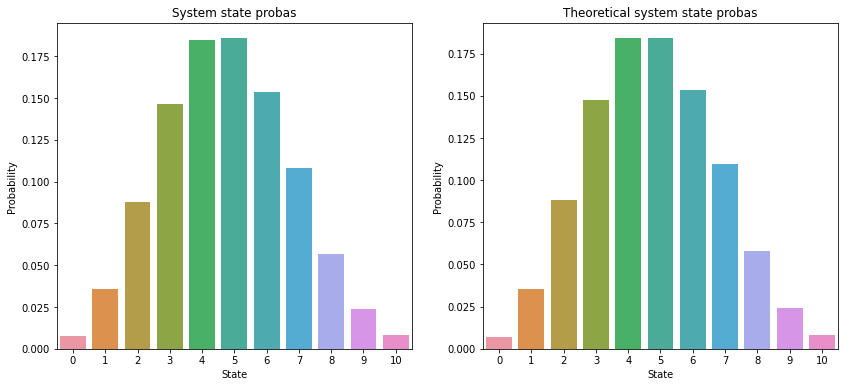

In [120]:
plot_hists(simulator)

In [121]:
stats_dataframe(simulator)

Характеристика,Значения для системы,Теоретические значения
Вероятность отказа,0.008197001617360356,0.008292852483801827
Абсолютная пропускная способность,0.9918029983826396,0.9917071475161982
Среднее число заявок в очереди,0.1293642192272892,0.13069535514471678
Среднее время пребывания заявки в очереди,4.755850785195191,4.762492704863915
Среднее число заявок в СМО,4.755850785195191,4.762492704863915
Среднее время пребывания заявки в СМО,0.1293642192272892,0.13069535514471678
Среднее число занятых каналов,4.626486565967902,4.631797349719198
